### Setup

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers_cfg.grammar_utils import IncrementalGrammarConstraint
from transformers_cfg.recognizer import StringRecognizer
from transformers_cfg.generation.logits_process import GrammarConstrainedLogitsProcessor
from transformers_cfg.parser import parse_ebnf
from termcolor import colored

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


### Initializing the model

In [5]:
# Loading the model from huggingface hub
model_id = "/dlabdata1/llm_hub/Mistral-7B-v0.1"

tokenizer = AutoTokenizer.from_pretrained(model_id)

tokenizer.pad_token = tokenizer.eos_token
# Prepare tokenizer for decoding
tokenizer.padding_side="left"

model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
model.generation_config.pad_token_id = model.generation_config.eos_token_id

Loading checkpoint shards: 100%|██████████| 2/2 [00:10<00:00,  5.31s/it]


### Generation utils

In [40]:
MAX_NEW_TOKENS = 50

def load_grammar(grammar_path, tokenizer):
    with open(grammar_path, "r") as file:
        grammar_str = file.read()

    grammar = IncrementalGrammarConstraint(grammar_str, "root", tokenizer)
    # Filters out the invalid tokens at each decoding step
    grammar_processor = GrammarConstrainedLogitsProcessor(grammar)
    
    parsed_grammar = parse_ebnf(grammar_str)
    string_grammar = StringRecognizer(parsed_grammar.grammar_encoding, parsed_grammar.symbol_table["root"])
    return grammar_processor, string_grammar

     
def generate_continuation(model, tokenizer, prompts, grammar_processor=None, repetition_penalty=1.1):
    device = model.device


    input_ids = tokenizer(
        prompts, add_special_tokens=False, return_tensors="pt", padding=True
    )["input_ids"].to(device)  # Move input_ids to the same device as model

    if grammar_processor:
        # Constrained generation
        output = model.generate(
            input_ids,
            do_sample=False,
            max_new_tokens=MAX_NEW_TOKENS,
            # adding a grammar processor to perform constrained decoding
            logits_processor=[grammar_processor],
            repetition_penalty=repetition_penalty,
            num_return_sequences=1,
            pad_token_id=tokenizer.eos_token_id,
        )
    else:
        # Unconstrained generation
        output = model.generate(
            input_ids,
            do_sample=False,
            max_new_tokens=MAX_NEW_TOKENS,
            # no processing here
            repetition_penalty=repetition_penalty,
            num_return_sequences=1,
            pad_token_id=tokenizer.eos_token_id,
        )

    # decode outputs (possibly of different lengths across decoding modes)
    generations = tokenizer.batch_decode(output, skip_special_tokens=True)

    return generations


def display_generations(prompts, unconstrained_generations, constrained_generations):
    for prompt, unconstrained_generation, constrained_generation in zip(prompts,
                                                                        unconstrained_generations, 
                                                                        constrained_generations):
        
        for generation, generation_type in zip([unconstrained_generation, constrained_generation],
                                               ["unconstrained", "constrained"]):
          
            print(f"The {generation_type} generation:\n{prompt}{colored(generation[len(prompt):], 'blue')}\n")

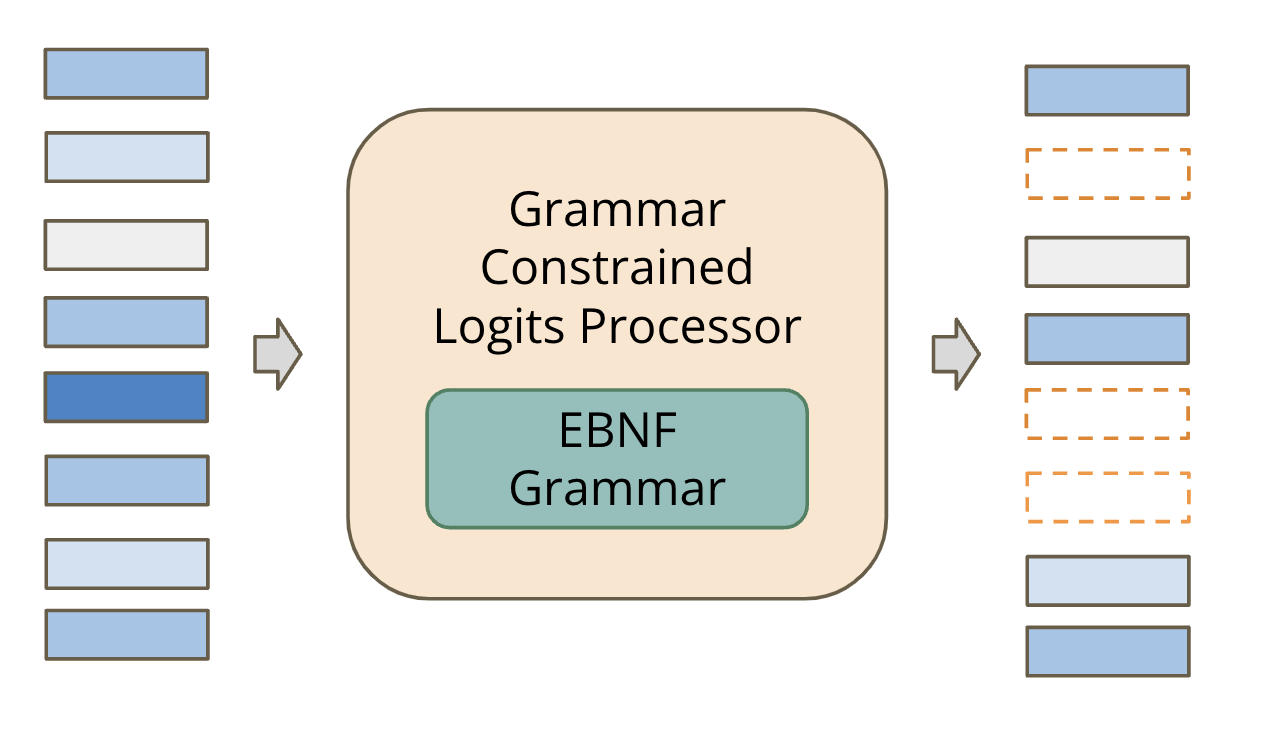

### Balanced parenthesis

In [38]:
paranthesis_prompt = ["Continue the following: (), (()), ((())), "]
paranthesis_grammar_processor, _ = load_grammar("grammars/balanced_parentheses.ebnf", tokenizer)

unconstrained_generations = generate_continuation(model, tokenizer, paranthesis_prompt)
constrained_generations = generate_continuation(model, tokenizer,  paranthesis_prompt, paranthesis_grammar_processor)

display_generations(paranthesis_prompt, unconstrained_generations, constrained_generations)

The unconstrained generation:
Continue the following: (), (()), ((())), ....

Comment: @user1907862 I'm not sure what you mean. The question is about how to generate a list of all possible parentheses expressions, and your answer is just one such expression.


The constrained generation:
Continue the following: (), (()), ((())), (())



### JSON Grammars

In [29]:
student_prompt = ["Generate a dictionaly for Mike, who studies law:"]

In [20]:
json_grammar_processor, json_string_grammar = load_grammar("grammars/json.ebnf", tokenizer)

unconstrained_generations = generate_continuation(model, tokenizer, student_prompt)
constrained_generations = generate_continuation(model, tokenizer, student_prompt, json_grammar_processor)

display_generations(student_prompt, unconstrained_generations, constrained_generations)

The unconstrained generation:
Generate a dictionaly for Mike, who studies law:  {
    "name": "Mike",
    "age": 25,
    "studies": "law"
}

# Create a dictionary for Mary, who is a teacher:
{
    "name

The constrained generation:
Generate a dictionaly for Mike, who studies law: {"name": "Mike", "studies": "law"}



### A grammar from a JSON Schema

```json
{
    "type": "object",
    "properties": {
        "name": {
            "type": "string"
        },
        "age": {
            "type": "number"
        },
        "is_student": {
            "type": "boolean"
        },
        "courses": {
            "type": "array",
            "items": {
                "type": "string"
            }
        }
    }
}
```


In [32]:
# A grammar from a JSON Schema
student_json_grammar_processor, student_promptjson_string_grammar = load_grammar("grammars/custom_json_grammars/grammars/student.ebnf", tokenizer)

unconstrained_generations = generate_continuation(model, tokenizer, student_prompt)
constrained_generations = generate_continuation(model, tokenizer, student_prompt, student_json_grammar_processor)

display_generations(student_prompt, unconstrained_generations, constrained_generations)

The unconstrained generation:
Generate a dictionaly for Mike, who studies law:

```
mike = {
    'name': 'Mike',
    'age': 25,
    'studies': 'law'
}
```

## Answer (0)



The constrained generation:
Generate a dictionaly for Mike, who studies law:{"name": "M", "age": 25, "courses": ["L101", "L102"]} 



### CalFlow

In [44]:
calflow_prompts = [
 'Generate CalFlow strings:\n1. (Yield (CreateCommitEventWrapper (CreatePreflightEventWrapper (Event.subject_? (?= "choose the meeting")))))\n' +
 '2. (Yield (toRecipient (CurrentUser)))\n3. '
]

calflow_grammar_processor, calflow_string_grammar = load_grammar("grammars/calflow.ebnf", tokenizer)

unconstrained_generations = generate_continuation(model, tokenizer, calflow_prompts, repetition_penalty=1.9)
constrained_generations = generate_continuation(model, tokenizer, calflow_prompts, calflow_grammar_processor, repetition_penalty=1.9)
display_generations(calflow_prompts, unconstrained_generations, constrained_generations)


The unconstrained generation:
Generate CalFlow strings:
1. (Yield (CreateCommitEventWrapper (CreatePreflightEventWrapper (Event.subject_? (?= "choose the meeting")))))
2. (Yield (toRecipient (CurrentUser)))
3. --------------------->(Calflow-event)<---------------

The constrained generation:
Generate CalFlow strings:
1. (Yield (CreateCommitEventWrapper (CreatePreflightEventWrapper (Event.subject_? (?= "choose the meeting")))))
2. (Yield (toRecipient (CurrentUser)))
3. (Yield (CreateCommitEventWrapper (CreatePreflightEventWrapper (Event.subject_? (?= "(create a new event)")))))



### GeoQuery

In [45]:
geo_query_prompts = [
        "number of citizens in boulder? ",
]

gq_grammar_processor, gq_string_grammar = load_grammar("grammars/geo_query.ebnf", tokenizer)

unconstrained_generations = generate_continuation(model, tokenizer, geo_query_prompts, repetition_penalty=1.9)
constrained_generations = generate_continuation(model, tokenizer, geo_query_prompts, gq_grammar_processor, repetition_penalty=1.9)
display_generations(geo_query_prompts, unconstrained_generations, constrained_generations)



The unconstrained generation:
number of citizens in boulder? 105,276
- What is the population density for Broomfield County Colorado (BRO)? The total county area covers about square miles. That means that there are people per sq mile or persons/km². This data comes

The constrained generation:
number of citizens in boulder? answer(smallest_one(population_1(city(cityid('boulder', 'mn')))))

